In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib.animation as animation
from matplotlib import rc
plt.rcParams['animation.embed_limit'] = 50
rc('animation', html = 'jshtml')

In [2]:
def rk4(f,y0,dt,n,gamma):
  t = np.linspace(0, n * dt, n + 1)
  y = np.zeros((n+1, len(y0)))
  y[0] = y0
  for i in range(n):
    k1 = dt * f(t[i], y[i],gamma)
    k2 = dt * f(t[i] + 0.5 * dt, y[i] + 0.5 * k1,gamma)
    k3 = dt * f(t[i] + 0.5 * dt, y[i] + 0.5 * k2,gamma)
    k4 = dt * f(t[i] + dt, y[i] + k3,gamma)
    y[i + 1] = y[i] + (1/6) * (k1 + 2 * k2 + 2 * k3 + k4)
  return y,t

In [3]:
#Dispersion relation
R_dim = 30e3
R_nondim = R_dim/300e3
beta_dim = 2e-12
beta_nondim = beta_dim * 86400 * 300e3

#Fourier harmonics
S = 10 #spectral radius
N = 41

def omega(k,l):
    return -beta_nondim * k / (k**2 + l**2 + R_nondim**-2)

P = 5 #radius of peak
H = 0.0005 #0.005 #height of peak (max amplitude)

def A(k,l):
  return H * np.exp(-0.5*(k**2+l**2-P**2)**2/(2*P**2))

In [4]:
k,l = np.linspace(-S,S,N),np.linspace(-S,S,N)
K,L = np.meshgrid(k,l)
#np.random.seed(10)
phi = np.random.uniform(0,2*np.pi,size=(N,N))
omega_vals = omega(K,L)
A_vals = A(K,L)

def modulo_grid(x, y):
  x_mod = np.mod(x + np.pi, 2 * np.pi) - np.pi
  y_mod = np.mod(y + np.pi, 2 * np.pi) - np.pi
  return x_mod,y_mod

def streamfunction(t,pos):
  x_mod,y_mod = modulo_grid(*pos)
  psi = np.sum(A_vals * np.cos(K*x_mod + L*y_mod - omega_vals*t + phi))
  return psi

def f(t,pos,gamma):
  x_mod,y_mod = modulo_grid(*pos)
  x_mod,y_mod = pos[0],pos[1]
  dpsi_dx = -np.sum(A_vals * K * np.sin(K*x_mod + L*y_mod - omega_vals*t + phi))
  dpsi_dy = -np.sum(A_vals * L * np.sin(K*x_mod + L*y_mod - omega_vals*t + phi))
  dphi_dx = dpsi_dx
  dphi_dy = dpsi_dy

  u = gamma * dphi_dx - (1-gamma) * dpsi_dy
  v = gamma * dphi_dy + (1-gamma) * dpsi_dx

  return np.array([u,v])

In [8]:
#Randomly select initial points
num_points = 2000
x_coords = np.random.uniform(-np.pi, np.pi, num_points)
y_coords = np.random.uniform(-np.pi, np.pi, num_points)
initial_conditions = np.column_stack((x_coords, y_coords))
solutions = []

time_span = 200 #number of days
n = 2000 #number of time steps
dt = time_span / n #length of timestep
gamma = 0.4

for y0 in initial_conditions:
  y,t = rk4(f,y0,dt,n,gamma)
  solutions.append(y)

In [9]:
#Calculate path modulo basin
mod_solutions = []
for sol in solutions:
  mod_sol = np.apply_along_axis(lambda row: modulo_grid(row[0], row[1]), axis=1, arr=sol)
  mod_solutions.append(mod_sol)


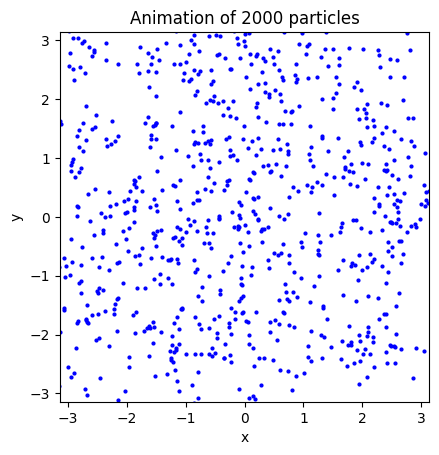

In [7]:
fig = plt.figure()
ax = plt.axes(xlim=(-np.pi, np.pi), ylim=(-np.pi, np.pi))
ax.set_aspect('equal')
ax.set_title('Animation of 2000 particles')
ax.set_xlabel('x')
ax.set_ylabel('y')
particles, = ax.plot([], [], 'bo', markersize=2)

def init():
    particles.set_data([], [])
    return particles,

def animate(i):
    x = [sol[i, 0] for sol in solutions]
    y = [sol[i, 1] for sol in solutions]
    particles.set_data(x, y)
    return particles,

ani = animation.FuncAnimation(fig, animate, frames=n, init_func=init, blit=True, interval=10)
ani.save('gammazero.mp4', writer='ffmpeg')

In [ ]:
ani.save('gammapoint1.mp4', writer='ffmpeg')

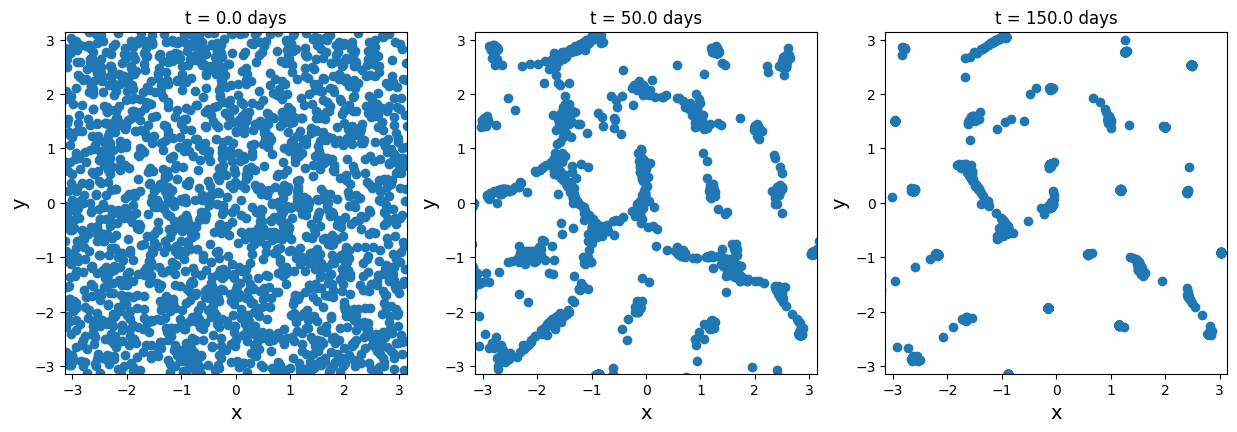

In [13]:
frames = [0,700,1400]
times = [0.0,50.0,150.0]
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,45))
for i,ax in enumerate((ax1,ax2,ax3)):
  x = [sol[frames[i], 0] for sol in solutions]
  y = [sol[frames[i], 1] for sol in solutions]
  ax.scatter(x,y)
  ax.set_xlabel('x',fontsize=14)
  ax.set_ylabel('y',fontsize=14)
  ax.set_aspect('equal')
  ax.set_xlim(-np.pi,np.pi)
  ax.set_ylim(-np.pi,np.pi)
  ax.set_title(f't = {times[i]} days')
plt.savefig('gamma04trajectories.png')